Now I want to add the simplex component to the previous analysis, which basically means extracting the correlations from within family differences.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
# figure out who is who in each trio
import glob
ped_file = '/data/sudregp/cnv/simplex.ped'
wes_prefix = ['CLIA', 'CCGO', 'WPS']
trios = []
affected = []
controls = []
samples = []
famids = []
fid = open(ped_file, 'r')
for line in fid:
    famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
    if fa[:4] in wes_prefix and mo[:4] in wes_prefix and sid[:4] in wes_prefix:
        fam = {}
        fam['child'] = sid
        if aff == '1':
            affected.append(sid)
        else:
            controls.append(sid)
        fam['father'] = fa
        fam['mother'] = mo
        fam['famid'] = famid
        trios.append(fam)
        samples += [sid, fa, mo]
        famids.append(famid)
fid.close()
samples = set(samples)
famids = set(famids)

fid = open('/data/sudregp/cnv/kid_samples.txt', 'r')
good_kids = [line.rstrip() for line in fid]
fid.close()

In [16]:
from itertools import combinations
from scipy import stats


def compute_correlations(files, diff=False, p_thresh=.05, x='ncnv', min_points=20):
    pcorrs = []
    scorrs = []
    ptitles, stitles = [], []
    for f in files:
        # open PLINK file and grab the burden for all kids
        df = pd.read_table(f, delimiter='\s+', index_col=1)
        kids = [t['child'] for t in trios]
        ncnv = []
        for kid in kids:
            idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
            ncnv.append(int(df.iloc[idx]['NSEG']))
        df3 = pd.DataFrame(ncnv, index=kids, columns=[x])
        data = pd.merge(df1, df2, left_on='ID', right_on='MRN')
        data = pd.merge(data, df3, left_on='code', right_index=True)
        y_cols = [c for c in data.columns if c not in ['code', 'ID', 'MRN', x]]
        
        if diff:
            # the idea is to create a new data frame that only has the differences
            # among the phenotypes
            y_cols = [c for c in data.columns if c not in ['code', 'ID', 'MRN', 'ncnv']]
            # loop through families
            rows = []
            for fam in famids:
                fam_kids = [t['child'] for t in trios if t['famid'] == fam]
                # get all combinations of kids
                if len(fam_kids) > 1:
                    for kid1, kid2 in combinations(fam_kids, 2):
                        if kid1 in good_kids and kid2 in good_kids:
                            row1 = data[data['code'] == kid1]
                            row2 = data[data['code'] == kid2]
                            new_row = [np.float(row1[y]) - np.float(row2[y])
                                       for y in (y_cols + ['ncnv'])]
                        rows.append(new_row)
            data = pd.DataFrame(rows, columns=(y_cols + ['ncnv']))

        # panda's corr() doesn't give p-vals, so let's do an ugly loop
        ps, ss = [], []
        for y in y_cols:
            tmp_df = data[[x, y]].dropna()
            r, p = stats.pearsonr(tmp_df.iloc[:,0], tmp_df.iloc[:,1])
            # make sure we have enough points to compute a decent correlation
            if p > p_thresh or tmp_df.shape[0] < min_points:
                r = np.nan
            ps.append(r)
            r, p = stats.spearmanr(tmp_df.iloc[:,0], tmp_df.iloc[:,1])
            if p > p_thresh or tmp_df.shape[0] < min_points:
                r = np.nan
            ss.append(r)
        # save the result if it's not NaN all across the board
        if not np.isnan(ps).all():
            pcorrs.append(ps)
            t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
            ptitles.append(t_str)
        if not np.isnan(ss).all():
            scorrs.append(ss)
            t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
            stitles.append(t_str)
            
    return (pd.DataFrame(pcorrs, index=ptitles, columns=y_cols),
            pd.DataFrame(scorrs, index=stitles, columns=y_cols))

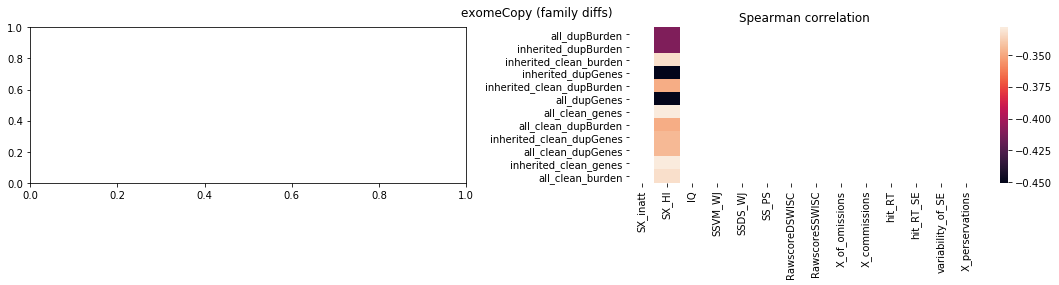

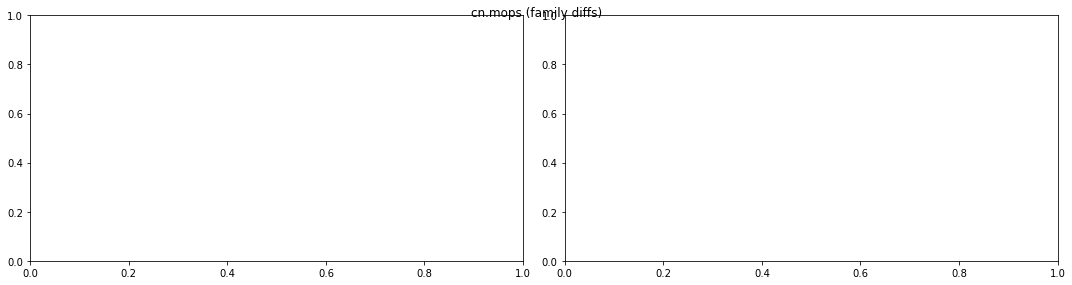

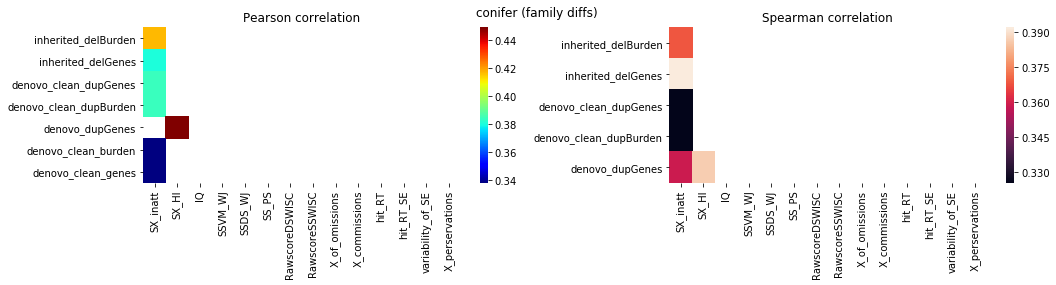

In [73]:
fname1 = '/home/sudregp/data/cnv/sx_simplex.csv'
pheno1 = pd.read_csv(fname1).drop(['Unnamed: 0', 'Date'], axis=1)
fname2 = '/home/sudregp/data/cnv/neuropsych_09062017.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/cnv/nisc_to_mrn.txt')

for tool in ['exomeCopy', 'cn.mops', 'conifer']:
    data_dir = '/home/sudregp/data/cnv/%s/' % tool
    files = glob.glob(data_dir + '/*cnv.indiv')
    pcorrs, scorrs = compute_correlations(files, diff=True, min_points=20)
    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    if pcorrs.shape[0] > 0:
        sns.heatmap(pcorrs, cmap='jet')
        plt.title('Pearson correlation')
    plt.subplot(1,2,2)
    if scorrs.shape[0] > 0:
        sns.heatmap(scorrs)
        plt.title('Spearman correlation')
    plt.suptitle('%s (family diffs)' % tool)
    plt.tight_layout()

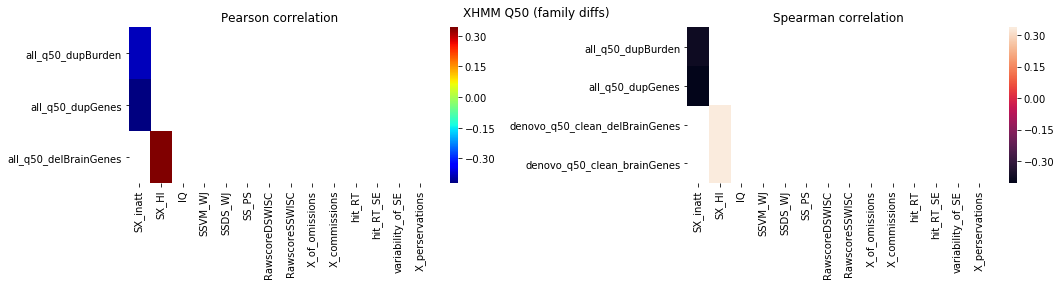

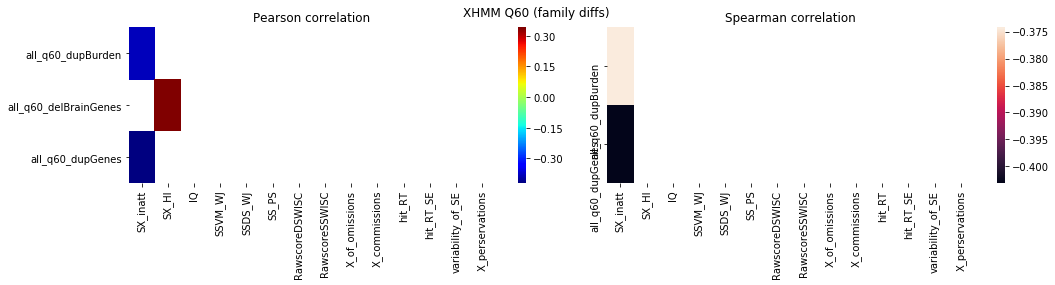

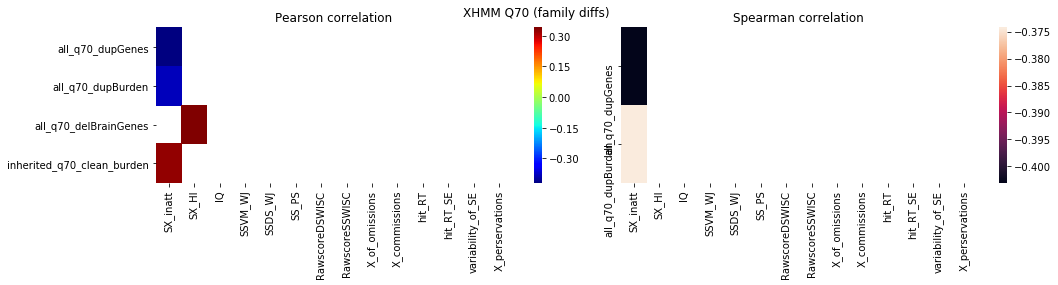

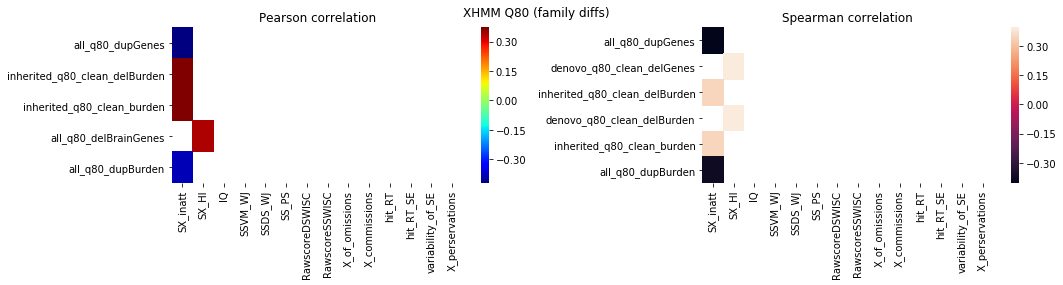

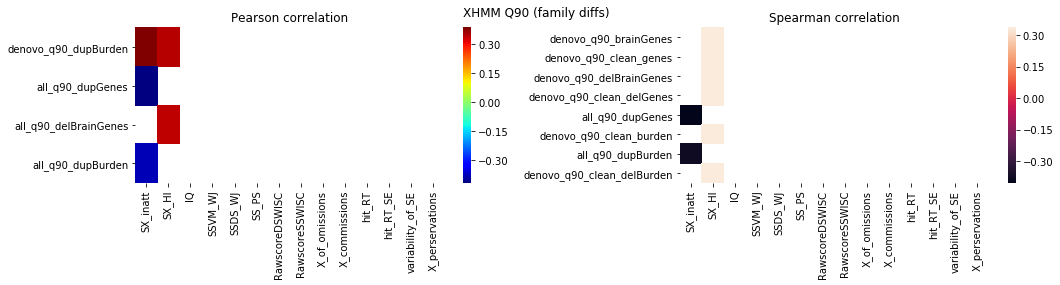

In [74]:
fname1 = '/home/sudregp/data/cnv/sx_simplex.csv'
pheno1 = pd.read_csv(fname1).drop(['Unnamed: 0', 'Date'], axis=1)
fname2 = '/home/sudregp/data/cnv/neuropsych_09062017.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/cnv/nisc_to_mrn.txt')

for q in [50, 60, 70, 80, 90]:
    data_dir = '/home/sudregp/data/cnv/xhmm/'
    files = [f for f in glob.glob(data_dir + '/*_q%d*cnv.indiv' % q) 
             if f.find('DATA') < 0]
    pcorrs, scorrs = compute_correlations(files, diff=True, min_points=20)
    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    if pcorrs.shape[0] > 0:
        sns.heatmap(pcorrs, cmap='jet')
        plt.title('Pearson correlation')
    if scorrs.shape[0] > 0:
        plt.subplot(1,2,2)
        sns.heatmap(scorrs)
        plt.title('Spearman correlation')
    plt.suptitle('XHMM Q%d (family diffs)' % q)
    plt.tight_layout()
    plt.show()

Now we only plot correlations when there is a minimum number of points to compute the correlations with.

Just keep in mind that the neuropsych file being used is not complete. For now I just want to get a better sense for what tool/QC to use. But it makes more sense to make the neuropsych file more complete only when we gather the neuropsych for the multiplex samples as well.

# Trying more complete phenotypes

This is the first try with a more complete phenotype file. Not all multikid re-runs are finished, so I'll have to re-run this later.

In [12]:
import glob
ped_file = '/data/sudregp/cnv/simplex.ped'
wes_prefix = ['CLIA', 'CCGO', 'WPS']

# cleaning up the data for this analysis
fid = open('/home/sudregp/data/cnv/exclude.txt', 'r')
exclude_list = [line.rstrip() for line in fid]
fid.close()
fid = open('/home/sudregp/data/cnv/exclude_multikids.txt', 'r')
exclude_list += [line.rstrip() for line in fid]
fid.close()

trios = []
affected = []
controls = []
samples = []
famids = []
fid = open(ped_file, 'r')
for line in fid:
    famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
    if (fa[:4] in wes_prefix and mo[:4] in wes_prefix and
        sid[:4] in wes_prefix and sid not in exclude_list):
        fam = {}
        fam['child'] = sid
        if aff == '1':
            affected.append(sid)
        else:
            controls.append(sid)
        fam['father'] = fa
        fam['mother'] = mo
        fam['famid'] = famid
        trios.append(fam)
        samples += [sid, fa, mo]
        famids.append(famid)
fid.close()
samples = set(samples)
famids = set(famids)
good_kids = [t['child'] for t in trios]

print 'Working with %d samples, in %d families' % (len(samples), len(famids))

Working with 88 samples, in 20 families


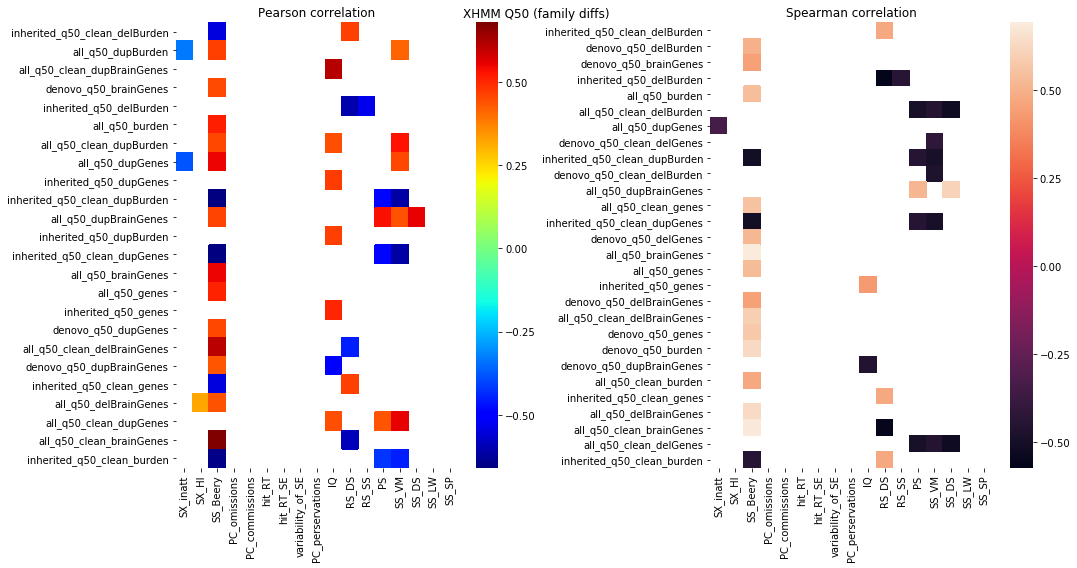

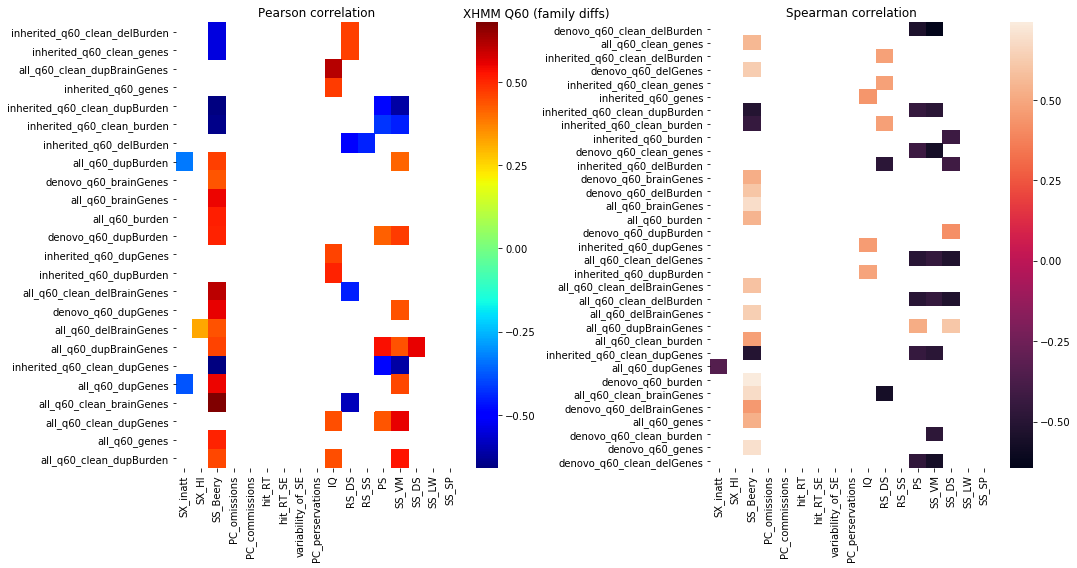

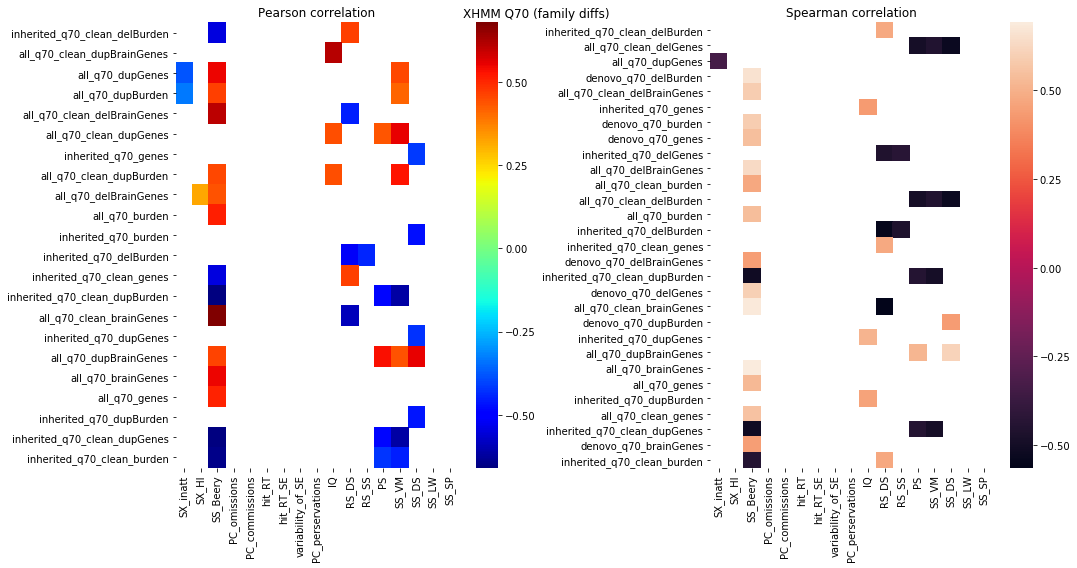

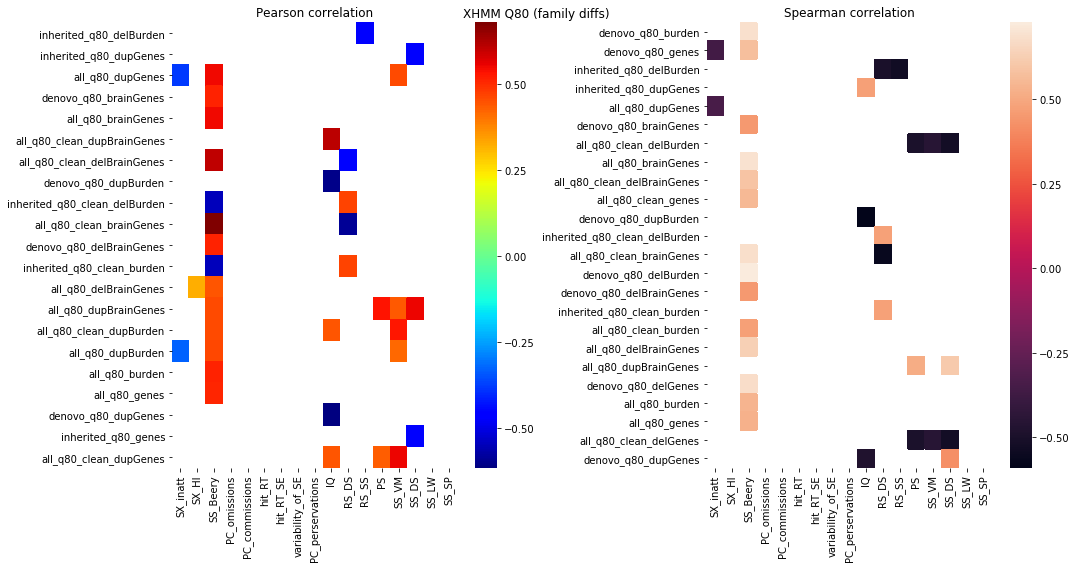

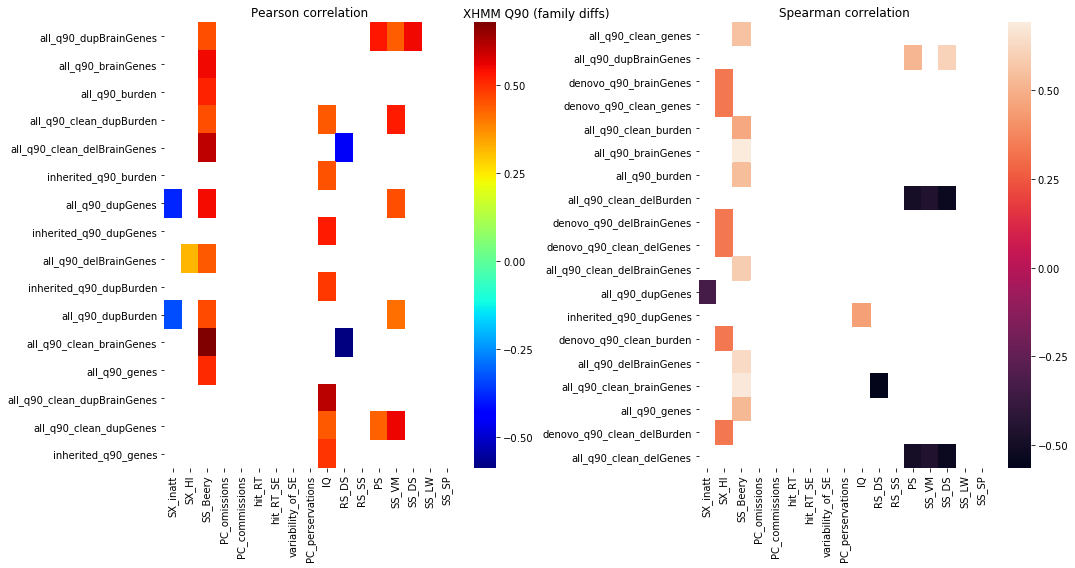

In [25]:
# note that even though I'm using the multiplex + simplex file, the trios 
# structure that is used by compute_correlations is based only on simplex
fname1 = '/home/sudregp/data/multiplex_simplex/sx_20180119.csv'
pheno1 = pd.read_csv(fname1)
fname2 = '/home/sudregp/data/multiplex_simplex/neuropsych_20180119_numbersOnly.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/multiplex_simplex/nisc_to_mrn.txt')

for q in [50, 60, 70, 80, 90]:
    data_dir = '/home/sudregp/data/cnv/xhmm_multikids/'
    files = [f for f in glob.glob(data_dir + '/*_q%d*cnv.indiv' % q) 
             if f.find('DATA') < 0]
    pcorrs, scorrs = compute_correlations(files, diff=True, min_points=20)
    
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    if pcorrs.shape[0] > 0:
        sns.heatmap(pcorrs, cmap='jet', yticklabels=True)
        plt.title('Pearson correlation')
    if scorrs.shape[0] > 0:
        plt.subplot(1,2,2)
        sns.heatmap(scorrs, yticklabels=True)
        plt.title('Spearman correlation')
    plt.suptitle('XHMM Q%d (family diffs)' % q)
    plt.tight_layout()
    plt.show()

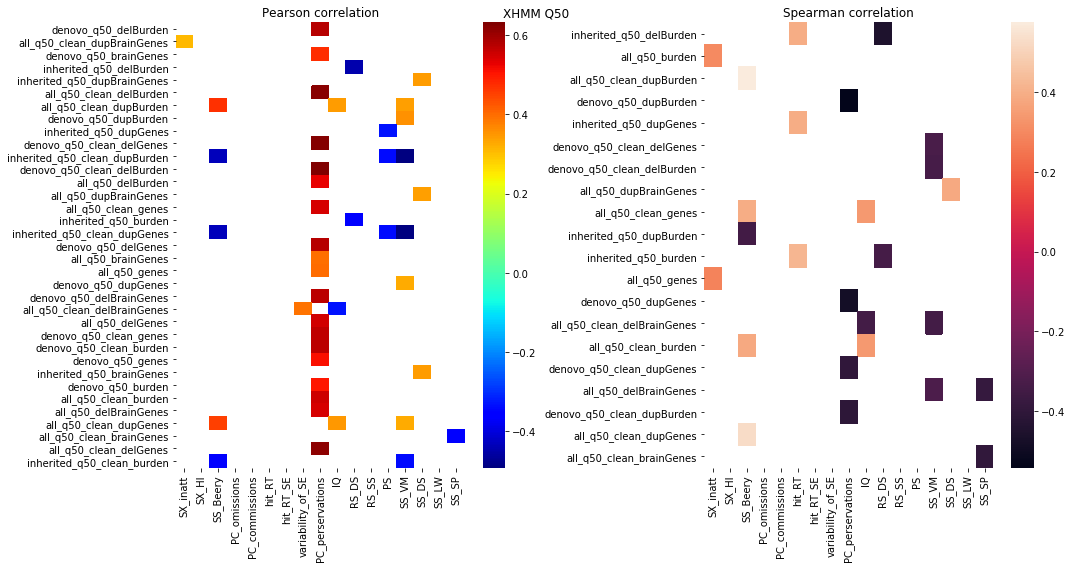

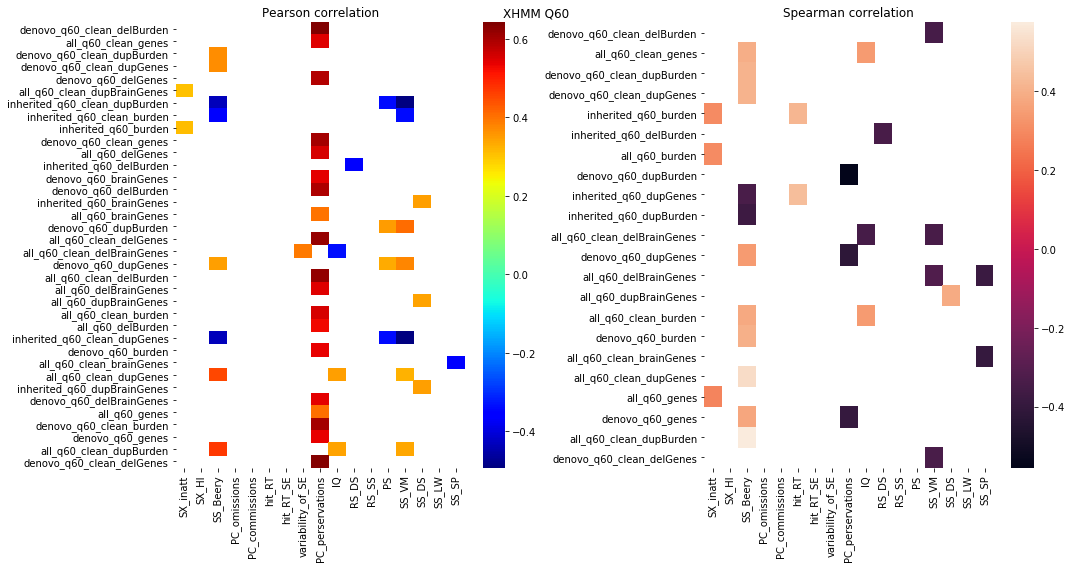

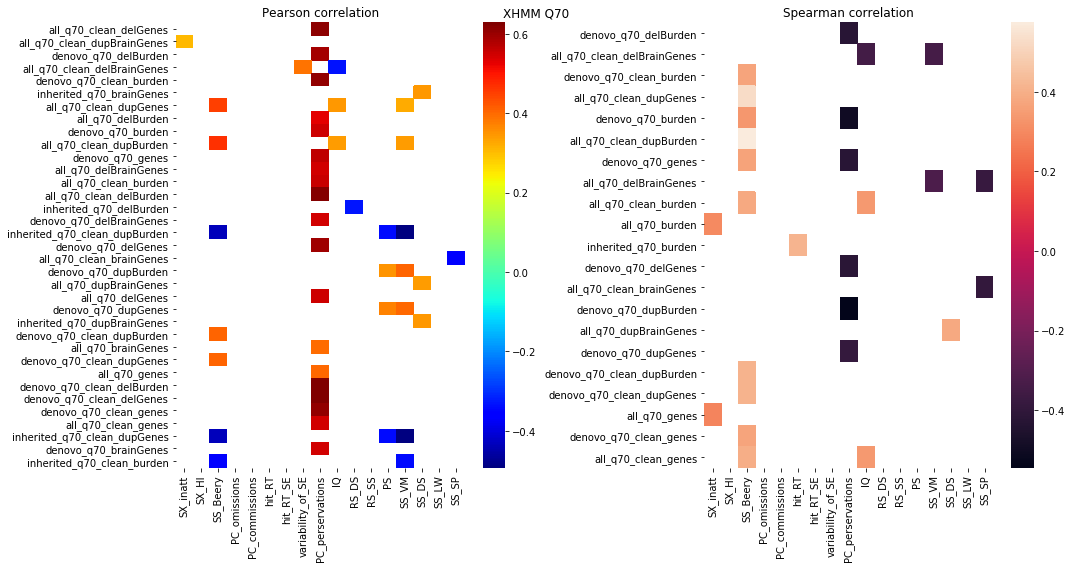

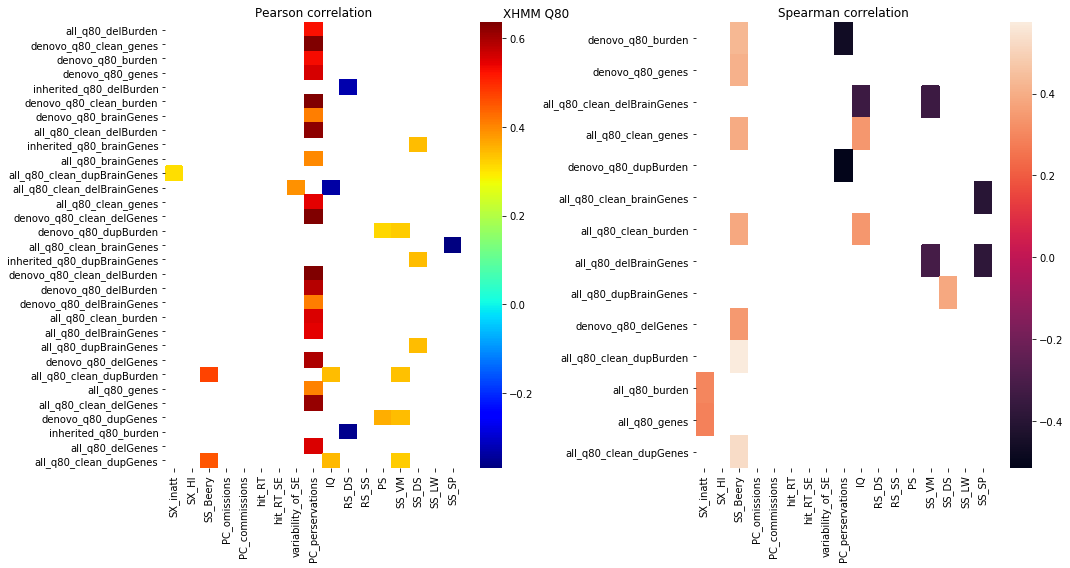

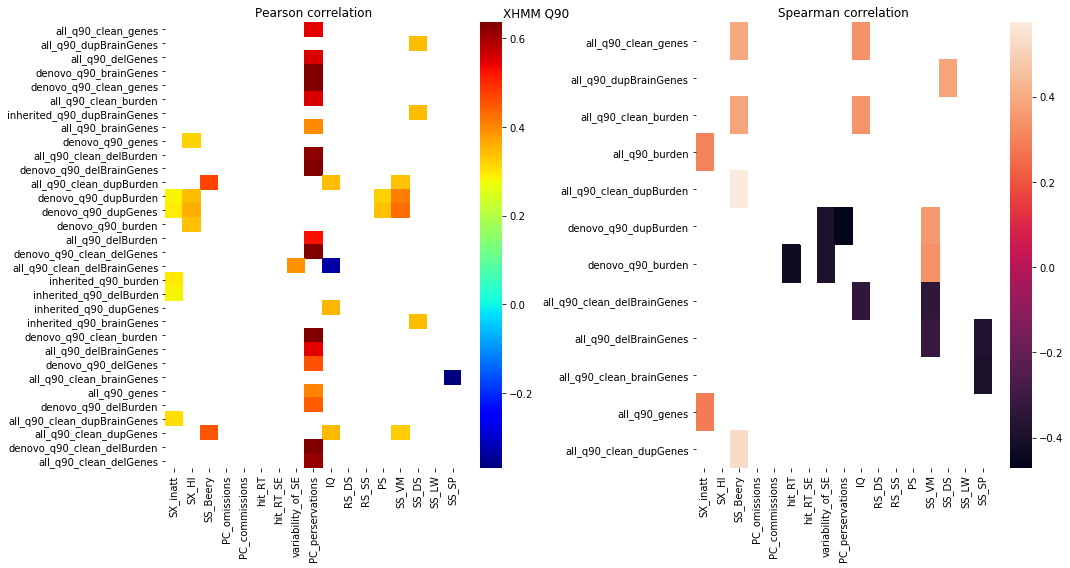

In [26]:
# note that even though I'm using the multiplex + simplex file, the trios 
# structure that is used by compute_correlations is based only on simplex
fname1 = '/home/sudregp/data/multiplex_simplex/sx_20180119.csv'
pheno1 = pd.read_csv(fname1)
fname2 = '/home/sudregp/data/multiplex_simplex/neuropsych_20180119_numbersOnly.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/multiplex_simplex/nisc_to_mrn.txt')

for q in [50, 60, 70, 80, 90]:
    data_dir = '/home/sudregp/data/cnv/xhmm_multikids/'
    files = [f for f in glob.glob(data_dir + '/*_q%d*cnv.indiv' % q) 
             if f.find('DATA') < 0]
    pcorrs, scorrs = compute_correlations(files, min_points=20)
    
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    if pcorrs.shape[0] > 0:
        sns.heatmap(pcorrs, cmap='jet', yticklabels=True)
        plt.title('Pearson correlation')
    if scorrs.shape[0] > 0:
        plt.subplot(1,2,2)
        sns.heatmap(scorrs, yticklabels=True)
        plt.title('Spearman correlation')
    plt.suptitle('XHMM Q%d' % q)
    plt.tight_layout()
    plt.show()

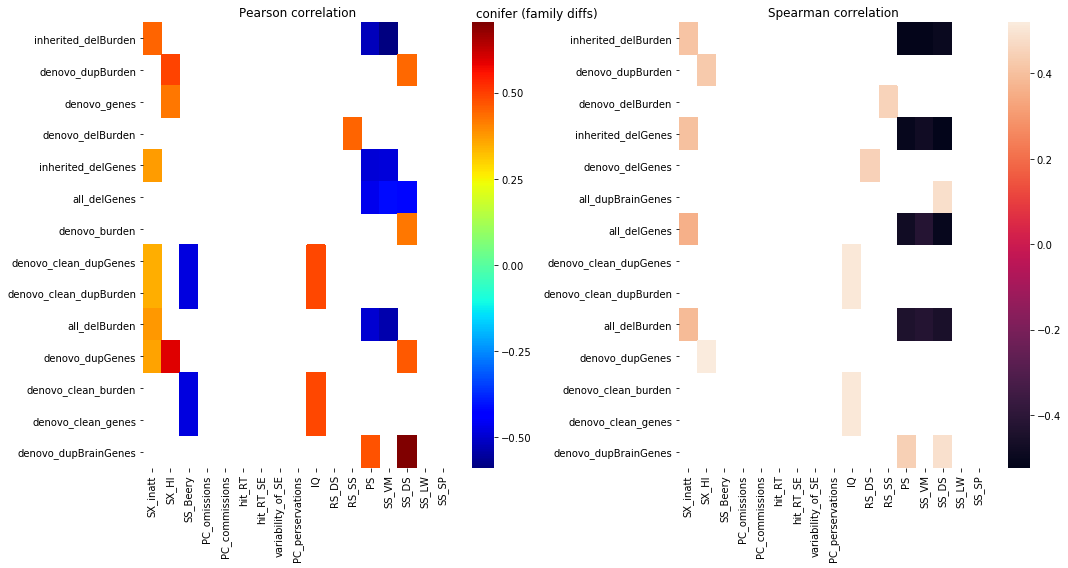

In [27]:
# note that even though I'm using the multiplex + simplex file, the trios 
# structure that is used by compute_correlations is based only on simplex
fname1 = '/home/sudregp/data/multiplex_simplex/sx_20180119.csv'
pheno1 = pd.read_csv(fname1)
fname2 = '/home/sudregp/data/multiplex_simplex/neuropsych_20180119_numbersOnly.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/multiplex_simplex/nisc_to_mrn.txt')

for tool in ['conifer']:#'exomeCopy', 'cn.mops']:
    data_dir = '/home/sudregp/data/cnv/%s_multikids/' % tool
    files = glob.glob(data_dir + '/*cnv.indiv')
    pcorrs, scorrs = compute_correlations(files, diff=True, min_points=20)
    
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    if pcorrs.shape[0] > 0:
        sns.heatmap(pcorrs, cmap='jet', yticklabels=True)
        plt.title('Pearson correlation')
    if scorrs.shape[0] > 0:
        plt.subplot(1,2,2)
        sns.heatmap(scorrs, yticklabels=True)
        plt.title('Spearman correlation')
    plt.suptitle('%s (family diffs)' % tool)
    plt.tight_layout()
    plt.show()

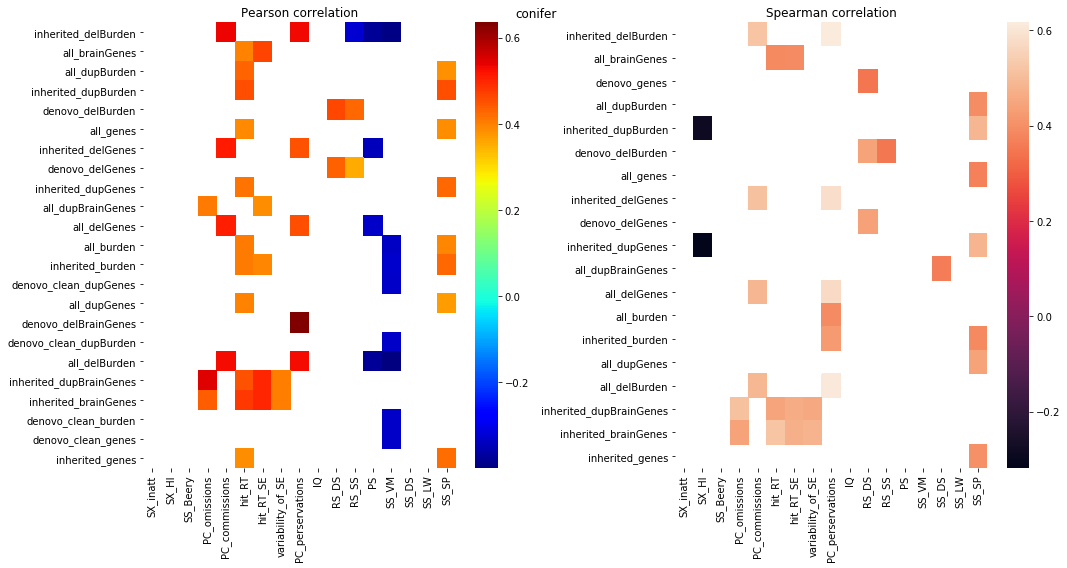

In [28]:
# note that even though I'm using the multiplex + simplex file, the trios 
# structure that is used by compute_correlations is based only on simplex
fname1 = '/home/sudregp/data/multiplex_simplex/sx_20180119.csv'
pheno1 = pd.read_csv(fname1)
fname2 = '/home/sudregp/data/multiplex_simplex/neuropsych_20180119_numbersOnly.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/multiplex_simplex/nisc_to_mrn.txt')

for tool in ['conifer']:#'exomeCopy', 'cn.mops']:
    data_dir = '/home/sudregp/data/cnv/%s_multikids/' % tool
    files = glob.glob(data_dir + '/*cnv.indiv')
    pcorrs, scorrs = compute_correlations(files, min_points=20)
    
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    if pcorrs.shape[0] > 0:
        sns.heatmap(pcorrs, cmap='jet', yticklabels=True)
        plt.title('Pearson correlation')
    if scorrs.shape[0] > 0:
        plt.subplot(1,2,2)
        sns.heatmap(scorrs, yticklabels=True)
        plt.title('Spearman correlation')
    plt.suptitle('%s' % tool)
    plt.tight_layout()
    plt.show()

# TODO
 * replot last two cells above if the computations for exomecopy and cnmops are done.
 * check results for multiplex (outlier samples, etc) and plot the non-diff plots using all multiplex+simplex samples, and then the diff plots using the same computations but only the simplex families.
 * try different similarity metrics (could use one of the many nonlinear methods in sklearn, but then would need to derive p-values through permutation!)
 * play with each tool parameters to see if we can get better results